In [92]:
import matplotlib.pyplot as plt

def plot2d(data):
	data.plot(kind='scatter', x='Easting', y='Northing')

def plot3d(data, title):
	fig = plt.figure()
	ax = fig.add_subplot(projection='3d')
	ax.scatter(data['Easting'], data['Northing'], data['WaterDepth'], label='Telemetry')
	ax.legend()
	ax.set_xlabel('Easting')
	ax.set_ylabel('Northing')
	ax.set_zlabel('WaterDepth')
	ax.set_title(title)
	plt.show()

In [1]:
import pandas as pd

telemetry = pd.read_csv('./telemetry_cleaned.csv')
X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10619) ## datetime

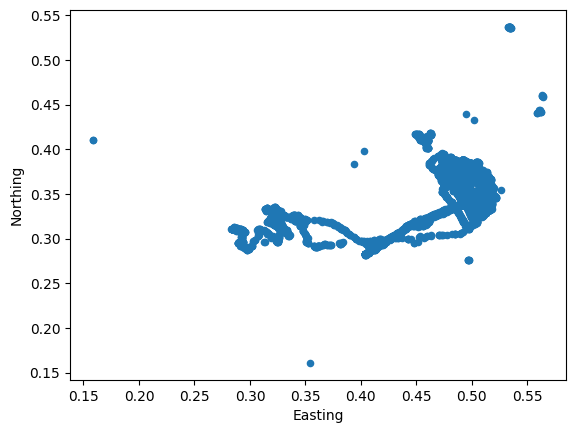

In [3]:
plot2d(X)

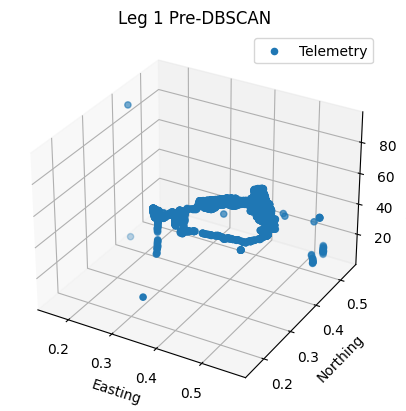

In [93]:
plot3d(X, 'Leg 1 Pre-DBSCAN')

## DBSCAN

In [2]:
def num_of_clusters(db):
	return len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

### Grid Search function

This function accepts an input dataset and a list of options. The function will iterate through each combination of these options in order to find the best results.

In [9]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import itertools

def grid_search_dbscan(data, options, verbose=False):
	results = []

	# Iterate through all combinations of options
	# And perform a DBSCAN evaluation on each
	option_combs = itertools.product(*options.values())

	for eps, min_samples in list(option_combs):
		if verbose: print(f'Running eps={eps}, min_samples={min_samples}')

		db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
		labels = db.labels_

		# Get estimated number of clusters and noise points
		clusters = num_of_clusters(db)
		noise = list(labels).count(-1)

		# Silhouette Coefficient
		silhouette = metrics.silhouette_score(X, labels)

		# Davies-Bouldin Score
		davies_bouldin = metrics.davies_bouldin_score(X, labels)

		if verbose: print(f'Finished with silhouette={silhouette}, davies={davies_bouldin}')

		results.append({
			'eps': eps,
			'min_samples': min_samples,
			'clusters': clusters,
			'noise': noise,
			'silhouette': silhouette,
			'davies_bouldin': davies_bouldin
		})

	return pd.DataFrame(results)

### Evaluation
DBSCAN parameters based on scikit learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

Unsupervised clustering metrics based on scikit learn [documentation](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics).

In [10]:
# Run grid search with the following options
options = {
	"eps": [0.1, 0.15, 0.2, 0.3],
	"min_samples": [5, 8, 10, 12]
}

results = grid_search_dbscan(X, options, True)

Running eps=0.1, min_samples=5
Finished with silhouette=0.5307406898857515, davies=8.631289731871675
Running eps=0.1, min_samples=8
Finished with silhouette=0.5947093068216549, davies=2.187707083606001
Running eps=0.1, min_samples=10
Finished with silhouette=0.5917124421092448, davies=5.53815522495031
Running eps=0.1, min_samples=12
Finished with silhouette=0.5841169366881906, davies=3.9217753216408995
Running eps=0.15, min_samples=5
Finished with silhouette=0.40548839505636963, davies=1.2731073741675079
Running eps=0.15, min_samples=8
Finished with silhouette=0.4675345207874299, davies=1.3184138859545431
Running eps=0.15, min_samples=10
Finished with silhouette=0.6955563873811347, davies=1.112270921981551
Running eps=0.15, min_samples=12
Finished with silhouette=0.6141712640604552, davies=1.3106177782754416
Running eps=0.2, min_samples=5
Finished with silhouette=0.40537185720250546, davies=0.7986184841973869
Running eps=0.2, min_samples=8
Finished with silhouette=0.4520962477922468, d

Analysing the results

In [11]:
results

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.10,5,20,201,0.530741,8.631290
1,0.10,8,21,283,0.594709,2.187707
2,0.10,10,20,347,0.591712,5.538155
3,0.10,12,21,411,0.584117,3.921775
4,0.15,5,6,124,0.405488,1.273107
5,0.15,8,10,146,0.467535,1.318414
6,0.15,10,11,185,0.695556,1.112271
7,0.15,12,13,219,0.614171,1.310618
8,0.20,5,7,90,0.405372,0.798618
9,0.20,8,4,117,0.452096,1.111159


Settings with highest silhouette

In [25]:
results.sort_values(by='silhouette', ascending=False).head(5)

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
6,0.15,10,11,185,0.695556,1.112271
7,0.15,12,13,219,0.614171,1.310618
1,0.10,8,21,283,0.594709,2.187707
2,0.10,10,20,347,0.591712,5.538155
3,0.10,12,21,411,0.584117,3.921775


The highest has eps=0.15, min_samples=10, sil=69.55

We can see that as the silhouette score decreases, the number of clusters and noise points increases. It may be such that a higher silhouette score may not necessarily yield better results.

eps=0.1, min_samples=10 has the best balance of clusters, noise, silhouette score and davies-bouldin score. So while eps=0.15, min_samples=10 produces the best silhouette, the former may produce a better visualisation.

Settings with highest number of noise points

In [27]:
results.sort_values(by='noise', ascending=False).head(5)

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
3,0.10,12,21,411,0.584117,3.921775
2,0.10,10,20,347,0.591712,5.538155
1,0.10,8,21,283,0.594709,2.187707
7,0.15,12,13,219,0.614171,1.310618
0,0.10,5,20,201,0.530741,8.631290


eps=0.1, min_samples=12, noise=411

### Fine-tuning
We can attempt to hone the results by using more granular steps in epsilon and min_samples values.

Min_samples values surrounding 10 appear to perform consistently well, while a range of 0.1-0.15 has been selected for the eps due to varying silhouette score and clustering results.

In [28]:
# Run grid search with the following options
options = {
	"eps": [0.1, 0.12, 0.13, 0.14, 0.15],
	"min_samples": [9, 10, 11]
}

results_ft = grid_search_dbscan(X, options, True)

Running eps=0.1, min_samples=9
Finished with silhouette=0.5872143495226707, davies=3.0719884421124704
Running eps=0.1, min_samples=10
Finished with silhouette=0.5917124421092448, davies=5.53815522495031
Running eps=0.1, min_samples=11
Finished with silhouette=0.5870974137116374, davies=12.40943399342615
Running eps=0.12, min_samples=9
Finished with silhouette=0.5305256609307976, davies=1.9856644300677422
Running eps=0.12, min_samples=10
Finished with silhouette=0.5768344187091536, davies=2.212357070436464
Running eps=0.12, min_samples=11
Finished with silhouette=0.5915467937555835, davies=2.5148084402460986
Running eps=0.13, min_samples=9
Finished with silhouette=0.5324850372362526, davies=1.6472006970942097
Running eps=0.13, min_samples=10
Finished with silhouette=0.5309155771434678, davies=1.659132491397977
Running eps=0.13, min_samples=11
Finished with silhouette=0.5333044648385822, davies=1.7940312185064855
Running eps=0.14, min_samples=9
Finished with silhouette=0.6119503406100908

In [29]:
results_ft

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.10,9,21,311,0.587214,3.071988
1,0.10,10,20,347,0.591712,5.538155
2,0.10,11,22,370,0.587097,12.409434
3,0.12,9,17,239,0.530526,1.985664
4,0.12,10,17,285,0.576834,2.212357
5,0.12,11,18,313,0.591547,2.514808
6,0.13,9,17,215,0.532485,1.647201
7,0.13,10,17,230,0.530916,1.659132
8,0.13,11,16,263,0.533304,1.794031
9,0.14,9,15,199,0.611950,1.580923


Settings with highest number of noise points

In [31]:
results_ft.sort_values(by='noise', ascending=False).head(5)

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
2,0.10,11,22,370,0.587097,12.409434
1,0.10,10,20,347,0.591712,5.538155
5,0.12,11,18,313,0.591547,2.514808
0,0.10,9,21,311,0.587214,3.071988
4,0.12,10,17,285,0.576834,2.212357


We can see that eps=0.1, min_samples=11 identifies the highest number of noise points. It also selects the highest number of clusters, as well as the highest davies-boulding score.

We can then use the best parameters to perform DBSCAN and apply the labels to the dataset:

In [40]:
best = results_ft.sort_values(by='noise', ascending=False, ignore_index=True).iloc[0]

In [44]:
db = DBSCAN(eps=best['eps'], min_samples=int(best['min_samples'])).fit(X)
X_labeled = X.copy(deep=True)
X_labeled['Label'] = db.labels_
X_labeled.head(5)

,Easting,Northing,WaterDepth,Label
0,0.158187,0.410159,92.93,-1
1,0.158187,0.410159,5.86,-1
2,0.534407,0.535898,5.86,-1
3,0.534311,0.535924,6.33,-1
4,0.533734,0.536254,7.02,-1


We can then filter out rows with a label of -1 to denoise the dataset

In [45]:
X_denoised = X_labeled[X_labeled['Label'] != -1]
print(f'{X_labeled.shape[0] - X_denoised.shape[0]} points removed')

370 points removed


### Plot results
The following code was obtained from [scikit learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py).

In [61]:
import numpy as np

def plot_clusters(db, show_noise=True):
	unique_labels = set(db.labels_)
	core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True

	colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

	for k, color in zip(unique_labels, colors):
		if k == -1 and show_noise:
			# Black used for noise
			color = [0, 0, 0, 1]
			print('noise')

		class_member_mask = db.labels_ == k

		core_samples = X[class_member_mask & core_samples_mask]

		plt.plot(
			core_samples['Easting'],
			core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=10,
		)

		non_core_samples = X[class_member_mask & ~core_samples_mask]
		plt.plot(
			non_core_samples['Easting'],
			non_core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=5,
		)

	plt.title(f'Estimated clusters: {num_of_clusters(db)}')
	plt.show()

noise


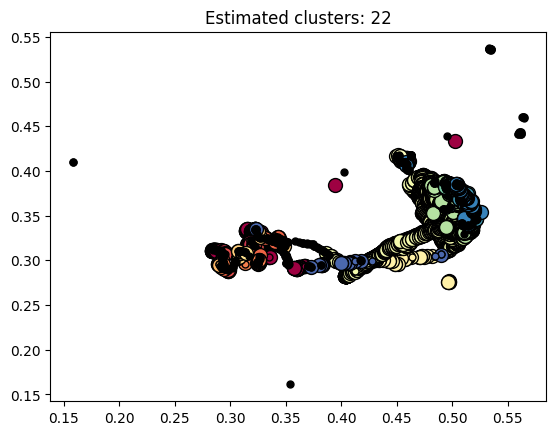

In [62]:
plot_clusters(db)

After denoised:

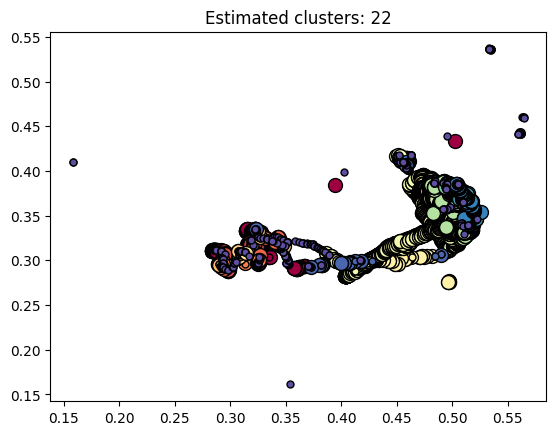

In [63]:
plot_clusters(db, False)

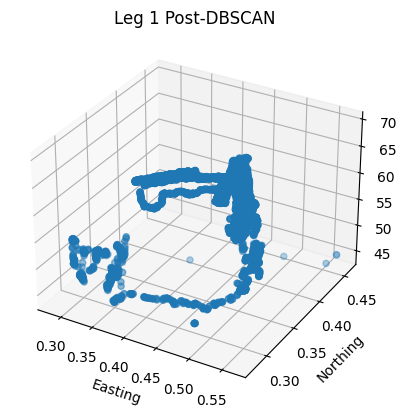

In [64]:
plot3d(X_denoised, 'Leg 1 Post-DBSCAN')

Let's filter the original dataset and plot the same graph to get a better comparison:

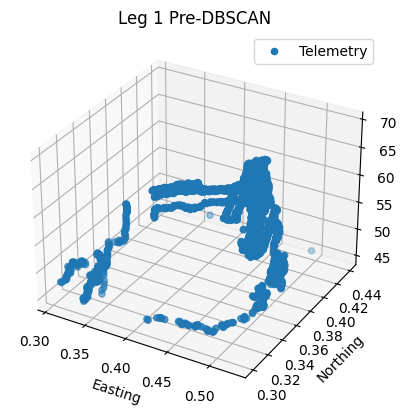

In [103]:
X_filter = X[X['WaterDepth'] >= 45]
X_filter = X_filter[X_filter['WaterDepth'] <= 70]
X_filter = X_filter[X_filter['Easting'] >= 0.3]
X_filter = X_filter[X_filter['Easting'] <= 0.55]
X_filter = X_filter[X_filter['Northing'] >= 0.3]
X_filter = X_filter[X_filter['Northing'] <= 0.45]
plot3d(X_filter, 'Leg 1 Pre-DBSCAN')

## Exporting Data

Finally, we can export the denoised data to CSV format to be used by the API

In [14]:
X_denoised.head(5)

,Easting,Northing,WaterDepth,Label
21,0.561481,0.442006,44.73,0
83,0.292306,0.308800,44.17,0
84,0.291969,0.308851,44.33,0
85,0.291128,0.308927,44.78,0
86,0.291152,0.308902,44.49,0


In [16]:
# Re-add missing columns to keep Api code happy
X_denoised.assign(Date='20-02-27')
X_denoised.assign(Time='20:50:47.502')
X_denoised.assign(Roll=-6.3)
X_denoised.assign(Pitch=2.0)
X_denoised.assign(Heading=19.9)

X_denoised.to_csv('../Api/src/data/telemetry_denoised.csv', index=False)